In [1]:
import numpy as np
import torch 
import torch.distributions as dist
import matplotlib.pyplot as plt
import random
from scipy.stats import norm 

## Simple example to show the effect of the flows and of the functions $f_i$ on the JMVAE loss

### Difficultés
- Les distributions apprises sont décalées par rapport aux vraies distributions :--> bug à trouver (Remarque : on observe ça que ce soit avec ou sans flots)
- Echantillonner d'une loi gaussienne tronquée : tel que je l'ai implémenté on peut n'avoir aucun point dans le bon intervalle et du coup ça plante. 
Il faudrait peut-être faire une boucle while à la place
- A rajouter : sauvegarder le meilleur modèle sur la loss test.
- twister les distributions 

- Après c'est vrai que j'essaye d'approximer des distributions uniformes avec des déformations de gaussiennes donc c'est peut-être ça le problème. 


In [2]:
# Create an artificial dataset with a 2D latent space

# Fix the random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

def cartesian_to_polar(z):
    r = torch.sqrt(torch.sum(z**2,dim=1))
    phi = torch.angle(z[:,0] + 1j * z[:,1]) # -pi, pi
    s = (phi >0).int()
    return r, phi.abs(), s


N = 10000
# Une distribution uniforme sur le carré
z1 = dist.Uniform(-1,1).sample([N])
z2 = dist.Uniform(-1, 1).sample([N])
s = (z2 >0).int()
s1 = 0.01
s2 = 0.01
px_z = dist.Normal(z1, scale = s1)
py_z = dist.Normal(z2.abs(), scale=s2)
x = torch.stack([px_z.sample(), s], dim=1)
y = torch.stack([py_z.sample(), s], dim=1)

print(x.size())

data = [x,y]

torch.Size([10000, 2])


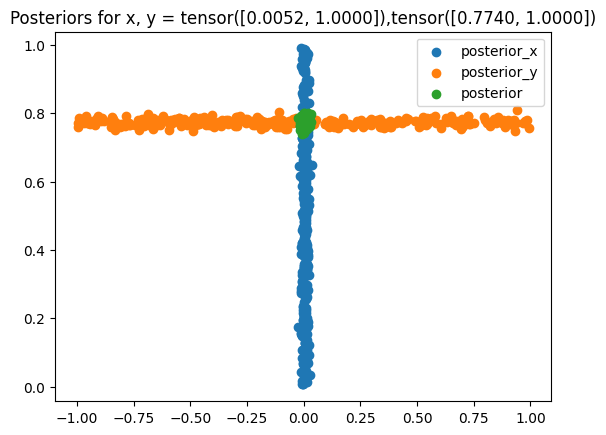

In [3]:


def sample_from_joint_posterior(x,y, K=100):
    assert(x[1]==y[1])
    # First sample from the true posterior
    
    # q(z1|x)
    z1s = []
    for i in range(K):

        z1 = dist.Normal(x[0], s1).sample([5000])
        idx = torch.argwhere((z1 >= -1)*(z1<=1))[0]
        z1s.append(z1[idx])
    
    z1s = torch.tensor(z1s)
    
    # q(phi|y)
    z2s = []
    for j in range(K):
        # print(point)
        samples = dist.Normal(y[0], s2).sample([5000])
        # print(samples)
        idx = torch.argwhere((samples <=1 )*( samples >= 0 ))[0]
        z2s.append(samples[idx])
    
    z2s = torch.tensor(z2s)
    
    
    # reconstruct the vector z
    # z = torch.stack([torch.cos(phi)*rs , (2*x[1]-1)* torch.sin(phi)*rs])
    z = torch.stack([z1s,(2*x[1]-1)* z2s], dim=1)
    return z




def sample_from_uni_posterior_x(x,K=100):

    # q(r|x)
    z1s = []
    for i in range(K):
        
        z1 = dist.Normal(x[0], s1).sample([5000])
        idx = torch.argwhere((z1 >= -1)*(z1 <=1))[0]
        z1s.append(z1[idx])
    
    z1s = torch.tensor(z1s)
    
    z2s = dist.Uniform(0, 1).sample([K]).squeeze()
    # print(phi.size())

    
    # reconstruct the vector z
    # z = torch.stack([torch.cos(phi)*rs , (2*x[1]-1)* torch.sin(phi)*rs])
    z = torch.stack([z1s,(2*x[1]-1)* z2s], dim=1)

    return z

def sample_from_uni_posterior_y(y,K=100):

    # q(phi|y)
    z2s = []
    for j in range(K):
        # print(point)
        samples = dist.Normal(y[0], s2).sample([5000])
        # print(samples)
        i = torch.argwhere((samples <= 1)*( samples >= 0 ))[0]
        z2s.append(samples[i])
    
    z2s = torch.tensor(z2s)
    z1s = dist.Uniform(-1,1).sample([K]).squeeze()
    # print(rs.size(),y[1])
    # reconstruct the vector zS
    # z = torch.stack([torch.cos(phi)*rs , (2*y[1]-1)* torch.sin(phi)*rs])
    z = torch.stack([z1s,(2*y[1]-1)* z2s], dim=1)
   
    return z

# print(x[0], y[0])
z_x = sample_from_uni_posterior_x(x[0], K=300)
z_y = sample_from_uni_posterior_y(y[0], K=300)
z_joint = sample_from_joint_posterior(x[0],y[0],K=300)
# print(z_x.shape)

# Plot the samples
plt.figure()
plt.scatter(z_x[:,0],z_x[:,1], label='posterior_x')
plt.scatter(z_y[:,0],z_y[:,1], label='posterior_y')
plt.scatter(z_joint[:,0],z_joint[:,1], label='posterior')
plt.title(f'Posteriors for x, y = {x[0]},{y[0]}')
plt.legend()



In [4]:
# Compute the true posterior loprob

def compute_joint_post_logprob(z,x,y):
    """Compute ln p(z|x,y) the true log value of the posterior

    Args:
        z tensor: the latent variable
        x tensor: first modality
        y tensor: second modality
    """
    
    assert(x[1] == y[1])
    

    r, phi, s = z[0],z[1].abs(), (z[1]>0).int()
    # print(r, phi, x[0], y[0])
    
    if x[1] != s:
        return torch.tensor(-np.inf)   
    # Compute ln p(x,y,z)
    
    lnpx_z = dist.Normal(r, s1).log_prob(x[0])
    lnpy_z = dist.Normal(phi, s2).log_prob(y[0])
    lnpz = dist.Uniform(-1,1).log_prob(r) + dist.Uniform(0,1).log_prob(phi) - np.log(2)
    
    lnp_xyz = lnpx_z + lnpy_z + lnpz
    
    
    # Compute ln p(x,y)
    px = norm(x[0],s1)
    lnpx = np.log(px.cdf(1)-px.cdf(-1)) - np.log(2)
    
    py = norm(y[0],s2)
    lnpy = np.log(py.cdf(1) - py.cdf(0)) - np.log(1)
    
    lnps = -np.log(2)
    
    lnp_xy = lnpx + lnpy + lnps
    
    return lnp_xyz - lnp_xy


compute_joint_post_logprob(z_joint[0],x[0],y[0])

tensor(7.2204)

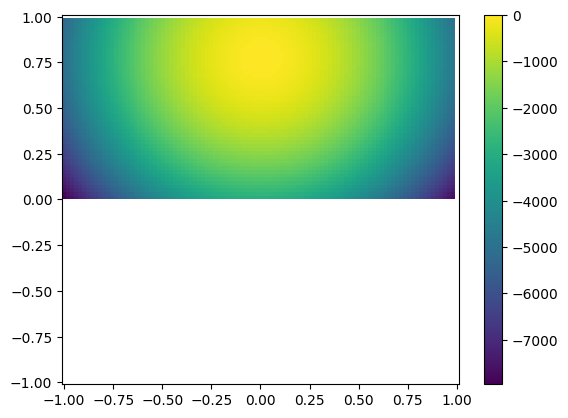

In [5]:
# Visualize the log probability function

s = np.linspace(-1,1,100)
X,Y = np.meshgrid(s,s)

Z = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(X[0])):
        z = torch.tensor([X[i,j],Y[i,j]])

        Z[i,j] = compute_joint_post_logprob(z, x[0],y[0])

plt.pcolormesh(X,Y,Z)
plt.colorbar()

In [6]:
from torch import nn
from bivae.my_pythae.models.vae_maf import my_VAE_MAF, VAE_MAF_Config
from bivae.my_pythae.models.vae import my_VAE
from pythae.models.vae import VAEConfig

def compute_all_posterior(x,y):
    
    latents = []
    lnp = []
    for i in range(len(x)):
        
        z = sample_from_joint_posterior(x[i],y[i], K=1)
        # print(z.size())
        latents.append(z)
        # lnp.append(compute_joint_post_logprob(z.squeeze(),x[i],y[i]))
    return torch.cat(latents), torch.tensor(lnp)


class my_model(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        vae = my_VAE_MAF
        vae_config = VAE_MAF_Config((1,2),latent_dim=2)
        self.vaes = nn.ModuleList([
            vae(model_config=vae_config),
            vae(model_config=vae_config)

        ])
        
    
    def compute_kld(self, data):
        """ Computes KL(q(z|x,y) || q(z|x)) + KL(q(z|x,y) || q(z|y))"""

        z_xy, qz_xy = compute_all_posterior(data[0],data[1])
        # print(z_xy.size())
        reg = 0
        details_reg = {}
        for m, vae in enumerate(self.vaes):
            flow_output = vae.flow(z_xy) if hasattr(vae, "flow") else vae.inverse_flow(z_xy)
            vae_output = vae.encoder(data[m].unsqueeze(1))
            mu, log_var, z0 = vae_output.embedding, vae_output.log_covariance, flow_output.out
            log_q_z0 = (-0.5 * (log_var + np.log(2*np.pi) + torch.pow(z0 - mu, 2) / torch.exp(log_var))).sum(dim=1)

            # kld -= log_q_z0 + flow_output.log_abs_det_jac
            # details_reg[f'kld_{m}'] = qz_xy.sum() - (log_q_z0 + flow_output.log_abs_det_jac).sum()
            details_reg[f'kld_{m}'] =  - (log_q_z0 + flow_output.log_abs_det_jac).sum()

            reg += details_reg[f'kld_{m}']
            
        return reg, details_reg
    
    def sample_from_x(self, x, K=100):
        
        d = torch.stack([x]*K)
        z = self.vaes[0](d).z
        return z
    
    def sample_from_y(self, y, K=100):
        d = torch.stack([y]*K)
        z = self.vaes[1](d).z
        return z
    
    


In [7]:
model = my_model()
model.compute_kld([d[:128] for d in data])
# model.sample_from_x(x[0])

print(VAE_MAF_Config.n_made_blocks)

3


In [8]:
# Now create a dataloader and train the flows

from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-5, amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer,'min')


n_train = 9000
n_test = N - n_train
data_train = TensorDataset(x[:n_train], y[:n_train])
data_test = TensorDataset(x[n_train:], y[n_train:])
train_loader = DataLoader(data_train, 256)
test_loader = DataLoader(data_test, 256, shuffle=False)

model.train()
best_test_loss = np.inf
for epoch in range(300):
    train_loss = 0
    model.train()
    for d in train_loader:

        loss,dict = model.compute_kld(d)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    test_loss = 0
    model.eval()
    for d in test_loader:
        with torch.no_grad():
            loss,dict = model.compute_kld(d)
            test_loss += loss.item()
    if test_loss < best_test_loss:
        torch.save(model.state_dict(), 'model.pt')
        best_test_loss = test_loss  
    scheduler.step(test_loss)
    print(f'Epoch {epoch} : train_loss {train_loss/len(data_train)}')
    print(f'Epoch {epoch} : test_loss {test_loss/len(data_test)}')



/home/agathe/Code/miniconda3/envs/myenv38/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 : train_loss 4.125530590481229
Epoch 0 : test_loss 3.989391845703125
Epoch 1 : train_loss 3.892084930419922
Epoch 1 : test_loss 3.739804138183594
Epoch 2 : train_loss 3.647244639078776
Epoch 2 : test_loss 3.4964246826171874
Epoch 3 : train_loss 3.418364583333333
Epoch 3 : test_loss 3.270004455566406
Epoch 4 : train_loss 3.213974856906467
Epoch 4 : test_loss 3.0773282470703127
Epoch 5 : train_loss 3.040476567586263
Epoch 5 : test_loss 2.905761962890625
Epoch 6 : train_loss 2.8933742404513887
Epoch 6 : test_loss 2.7675540161132814
Epoch 7 : train_loss 2.7679979112413196
Epoch 7 : test_loss 2.6372197265625
Epoch 8 : train_loss 2.6468537334865996
Epoch 8 : test_loss 2.509333740234375
Epoch 9 : train_loss 2.5167016593085396
Epoch 9 : test_loss 2.3681705322265625
Epoch 10 : train_loss 2.3707855665418838
Epoch 10 : test_loss 2.23764697265625
Epoch 11 : train_loss 2.2428553271823457
Epoch 11 : test_loss 2.1190644836425783
Epoch 12 : train_loss 2.1219598507351347
Epoch 12 : test_loss 2.

tensor([-0.8179,  0.0000]) tensor([0.6259, 0.0000])


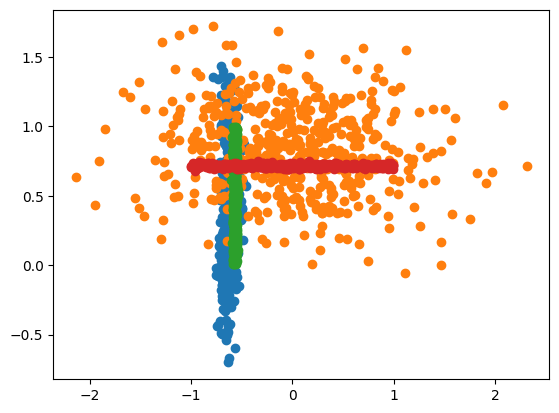

In [9]:
# Let's visualize the learned flows 

model = my_model()
model.load_state_dict(torch.load('model.pt'))
idx = 0
z_simulated_y = model.sample_from_y(y[i], K = 500).detach().cpu()
z_simulated_x = model.sample_from_x(x[i], K = 500).detach().cpu()

z_x = sample_from_uni_posterior_x(x[i], K=500)
z_y = sample_from_uni_posterior_y(y[i], K=500)

print(x[2],y[2])
plt.scatter(z_simulated_x[:,0],z_simulated_x[:,1])
plt.scatter(z_simulated_y[:,0],z_simulated_y[:,1])
plt.scatter(z_x[:,0], z_x[:,1])
plt.scatter(z_y[:,0], z_y[:,1])